# Extratropical Near Surface Air Temperature Extremes Notebook
This notebook looks at why the high percentile temperature days warm less quickly with global warming than the average summer day.

In [85]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

In [3]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Spin up
The net flux converges towards zero if the [actual surface pressure](https://jduffield65.github.io/Isca/namelists/main/spectral_dynamics/#ps) is used to [compute](https://jduffield65.github.io/Isca/code/utils/radiation/#isca_tools.utils.radiation.frierson_net_toa_sw_dwn) the net shortwave radiation at the top of the atmosphere.

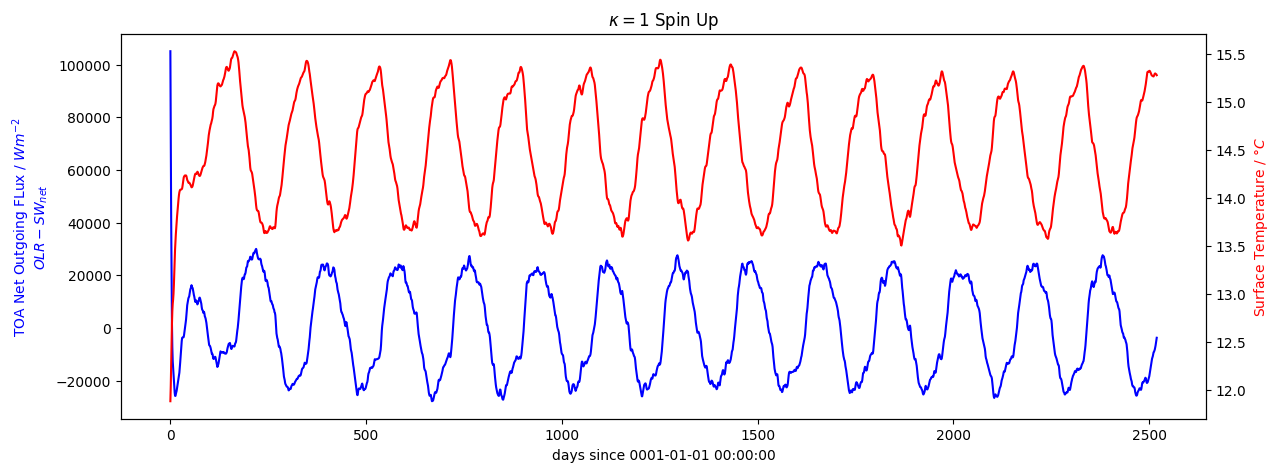

In [4]:
# Plot spin up time
spin_up_ind = np.where(np.asarray(tau_lw)==1)[0][0]     # Use dataset with earthlike optical depth for spin up plot
fig, ax = plt.subplots(1,1, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds[spin_up_ind].olr, frierson_net_toa_sw_dwn(ds[spin_up_ind].swdn_toa, ds[spin_up_ind].ps,
                                                                          albedo[spin_up_ind], tau_sw[spin_up_ind]),
                             ds[spin_up_ind].t_surf, ax)
plt.title('$\kappa = 1$ Spin Up');

## Get datasets
Get one dataset, `ds_quant`, for extratropics averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the summer.

In [5]:
# Get data set averaged over all summer days in extratropics.
# Do this for each optical depth value
use_time_start = 360*2
region = 'Extratropics'
lat_min = 30
lat_max = 60

temp_summer_av = np.zeros(n_exp)
ds_summer = []
for i in tqdm(range(n_exp)):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
    ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
    # Combine hemispheres and average over longitude, time and latitude.
    ds_use = xr.concat([ds_nh_summer.mean(dim=('lon', 'time')), ds_sh_summer.mean(dim=('lon', 'time'))], dim='lat').mean(dim='lat')
    ds_summer += [ds_use]
    ds_summer[i].load()     # Load in averaged dataset so later computation and conversion to numpy is much quicker
    temp_summer_av[i] = ds_summer[i].temp[-1]

100%|██████████| 7/7 [01:21<00:00, 11.64s/it]


In [6]:
# Get data set averaged over all days exceeding given quantile of near surface temperature in extratropics.
# Do this for each optical depth value
quantile = 99
temp_quant_av = np.zeros(n_exp)
ds_quant = []
for i in tqdm(range(n_exp)):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)    # Only latitude region
    # Collapse to single coordinate and then take quantile over it
    ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
    # quantile_thresh = np.quantile(ds_use.temp[-1].to_numpy(), quantile/100)
    quantile_thresh = ds_use.temp[-1].quantile(quantile/100, dim='lon_lat_time', keep_attrs=True)
    # Average each variable in data over days where near surface temperature exceeds this quantile
    ds_use = ds_use.where(ds_use.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)
    ds_quant += [ds_use]
    ds_quant[i].load()  # Load in averaged dataset so later computation and conversion to numpy is much quicker

    # Record mean extratropical near surface temperature
    temp_quant_av[i] = ds_quant[i].temp[-1]

100%|██████████| 7/7 [03:07<00:00, 26.72s/it]


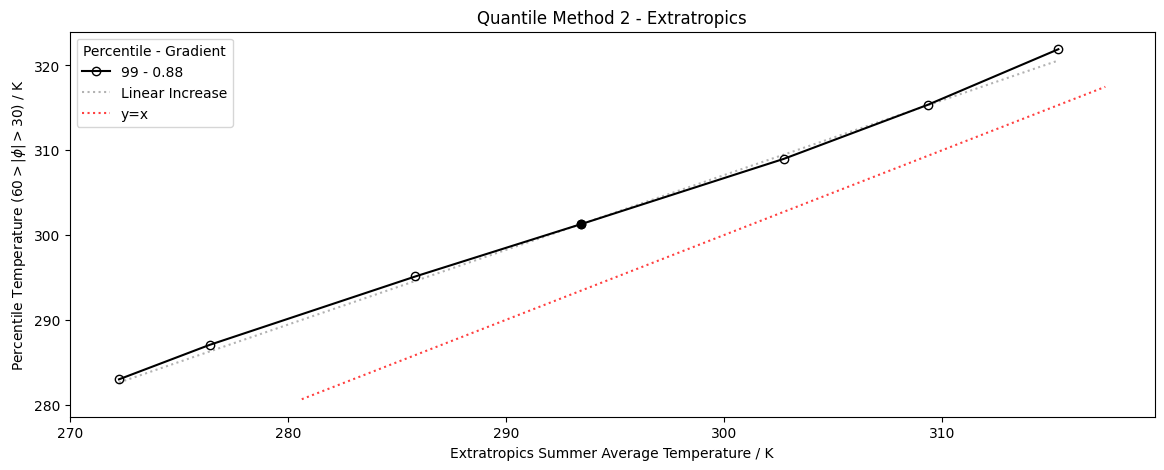

In [7]:
tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
fig, ax = plt.subplots(1,1, figsize=(14, 5))
fit_func = lambda x, m: temp_quant_av[tau_ref_ind] + m*(x-temp_summer_av[tau_ref_ind])         # Straight line through the ref point
gradient = scipy.optimize.curve_fit(fit_func,temp_summer_av, temp_quant_av)[0]
ax.plot(temp_summer_av, temp_quant_av, marker='o', label='{} - {:.2f}'.format(quantile, gradient[0]), color='k', fillstyle='none')
ax.plot(temp_summer_av[tau_ref_ind], temp_quant_av[tau_ref_ind], marker='o', color='k', fillstyle='full')
ax.plot(temp_summer_av, fit_func(temp_summer_av, gradient), linestyle=':', color='k', alpha=0.3, label='Linear Increase')

# # now plot y=x so can see how the rate compares to the increase of the mean
ax.plot([ax.get_ylim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
ax.legend(title='Percentile - Gradient')
ax.set_xlabel(f'{region} Summer Average Temperature / K')
ax.set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K')
ax.set_title(f'Quantile Method 2 - {region}');

The linear increase above and below is just a straight line fit that goes through the reference point, for which the optical depth parameter is 1.

The plot shows that, in the extratropics, the high percentile temperature days increase less quickly with global warming than the average summer day.



## Moist Static Energy Analysis

In a previous [notebook](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/aquaplanet/k%3D1/mse_notebook.ipynb), it is shown that for both the average summer day and the high percentile day in the extratropics, that the temperature profile is convectively neutral.

I.e., a dry adiabat is followed up to the lifting condensation level, above which the moist adiabat is followed. This means that in both cases, the surface MSE, $h$, is equal to the free troposphere MSE, $h^*$ (The * is because in the free troposphere, it is saturated).

This allows us to break down the contribution to the temperature based on the moist static energy of the average summer day, $\overline{h}$:

Average of days warmer than percentile $x$: $T_x = \frac{1}{c_p}(\bar{h}-gz + \Delta h^*-L_v q_x)$

Summer Average: $\bar{T} = \frac{1}{c_p}(\bar{h}-gz -L_v \bar{q})$


- The $q$ term refers to the near surface specific humidity.
- $\bar{h}$ is the average summer moist static energy. It is the same whether computed near surface or taking the saturated free troposphere value i.e. $\overline{h} = \overline{h^*}$.
- $\Delta h^*$ accounts for the difference between the moist static energy between the average summer day and the high percentile days. I.e. it basically quantifies the effect of anticyclones. This is the difference from the tropics, whereby the weak temperature gradfient would mean this term would be 0.
- $z$ is the geopotential height of the surface so very small.


In [8]:
# Calculate the 4 different MSE values: surface and saturated free troposphere for both summer and quantile datasets.
pressure_ft = 700
a = []
mse_surface_quant = np.zeros(n_exp)
mse_ft_sat_quant = np.zeros_like(mse_surface_quant)
mse_surface_summer = np.zeros_like(mse_surface_quant)
mse_ft_sat_summer = np.zeros_like(mse_surface_quant)

def mse_ft(dataset):
    # Calculate free troposphere saturated MSE for a given dataset in kJ/kg
    ds_use = dataset.sel(pfull=pressure_ft, method='nearest')
    mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use.temp), ds_use.pfull * 100)
    sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
    return moist_static_energy(ds_use.temp, sphum_sat, ds_use.height)

for i in tqdm(range(n_exp)):
    # surface MSE for quantile dataset
    mse_surface_quant[i] = moist_static_energy(ds_quant[i].temp[-1], ds_quant[i].sphum[-1], ds_quant[i].height[-1])
    # saturated free troposphere MSE for quantile dataset
    mse_ft_sat_quant[i] = mse_ft(ds_quant[i])
    # surface MSE for summer dataset
    mse_surface_summer[i] = moist_static_energy(ds_summer[i].temp[-1], ds_summer[i].sphum[-1], ds_summer[i].height[-1])
    # saturated free troposphere MSE for quantile dataset
    mse_ft_sat_summer[i] = mse_ft(ds_summer[i])

100%|██████████| 7/7 [00:00<00:00, 166.92it/s]


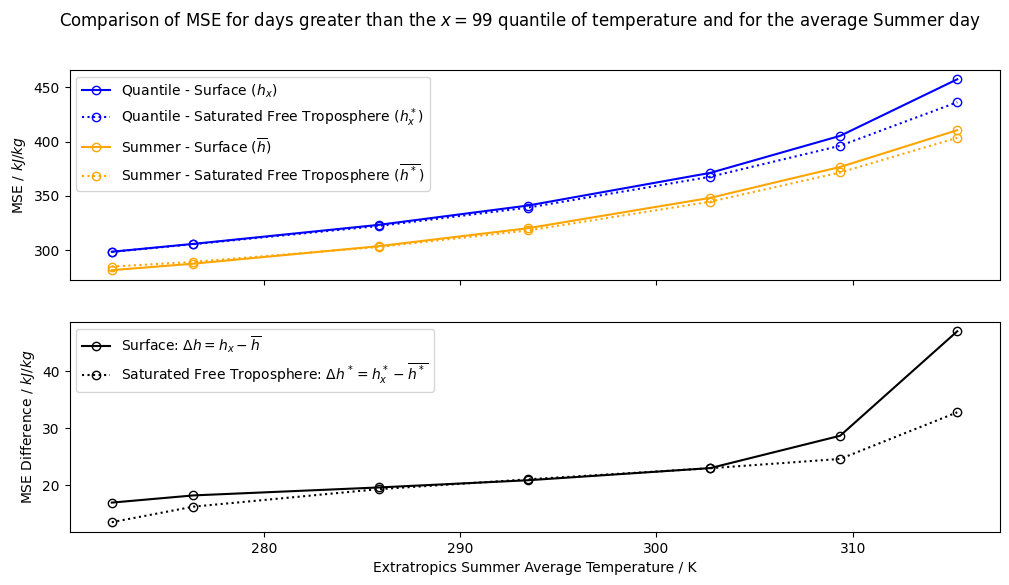

In [9]:
# Check surface and free troposphere saturated MSE are the same for each dataset
fig, ax = plt.subplots(2,1, figsize=(12, 6), sharex=True)
ax[0].plot(temp_summer_av, mse_surface_quant, color='b', marker='o', fillstyle='none', label = 'Quantile - Surface ($h_x$)')
ax[0].plot(temp_summer_av, mse_ft_sat_quant, color='b', marker='o', fillstyle='none', linestyle=':',
           label = 'Quantile - Saturated Free Troposphere ($h_x^*$)')
ax[0].plot(temp_summer_av, mse_surface_summer, color='orange', marker='o', fillstyle='none', label = 'Summer - Surface ($\\overline{h}$)')
ax[0].plot(temp_summer_av, mse_ft_sat_summer, color='orange', marker='o', fillstyle='none', linestyle=':',
           label = 'Summer - Saturated Free Troposphere ($\\overline{h^*}$)')

ax[1].plot(temp_summer_av, mse_surface_quant - mse_surface_summer, color='k', marker='o', fillstyle='none',
           label = 'Surface: $\Delta h = h_x - \\overline{h}$')
ax[1].plot(temp_summer_av, mse_ft_sat_quant - mse_ft_sat_summer, color='k', linestyle=':', marker='o',
           fillstyle='none', label = 'Saturated Free Troposphere: $\Delta h^* = h_x^* - \\overline{h^*}$')

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('MSE / $kJ/kg$')
ax[1].set_ylabel('MSE Difference / $kJ/kg$')
ax[1].set_xlabel(f'{region} Summer Average Temperature / K')
fig.suptitle(f'Comparison of MSE for days greater than the $x={quantile}$ quantile of temperature and for the average Summer day');

From the first plot above, the fact that the dotted and solid lines overlap for the lower 5 points confirms the results from the previous [notebook](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/aquaplanet/k%3D1/mse_notebook.ipynb), that the temperature profiles are convectively neutral for both high temperature quantile and average summer days.

The fact that they diverge for the last two points indicates that the temperature profiles may change from this for very high $CO_2$ concentrations.

The bottom plot shows that the $\Delta h$ term is the same, whether computed from the surface ($\Delta h$) or saturated free troposphere values ($\Delta h^*$), except for at very high $CO_2$ concentrations.

In [51]:
# Get the different contributions to the temperature

# Multiply MSE term by 1000 to get in units of J not kJ
# h_mean_term should be the same whether use surface or free troposphere but from orange solid and dotted lines do differ in above plot
# so don't get exactly the same results when doing this.
h_mean_term = mse_surface_summer * 1000 / c_p  # this is the same for both summer and quantile
delta_h_term = (mse_ft_sat_quant - mse_ft_sat_summer) * 1000 / c_p      # Account for different MSE between the days
# delta_h_term = (mse_surface_quant - mse_surface_summer) * 1000 / c_p      # Account for different MSE between the days

# Expect height terms to be very small but compute anyway to check
z_term_quant = -g * np.asarray([ds_quant[i].height[-1] for i in range(n_exp)]) / c_p
z_term_summer = -g * np.asarray([ds_summer[i].height[-1] for i in range(n_exp)]) / c_p

# Specific humidity term
q_term_quant = -L_v * np.asarray([ds_quant[i].sphum[-1] for i in range(n_exp)]) / c_p
q_term_summer = -L_v * np.asarray([ds_summer[i].sphum[-1] for i in range(n_exp)]) / c_p

# Get simulated temperature by adding up all the terms
temp_quant_sim = h_mean_term + delta_h_term + z_term_quant + q_term_quant
temp_summer_sim = h_mean_term + z_term_summer + q_term_summer

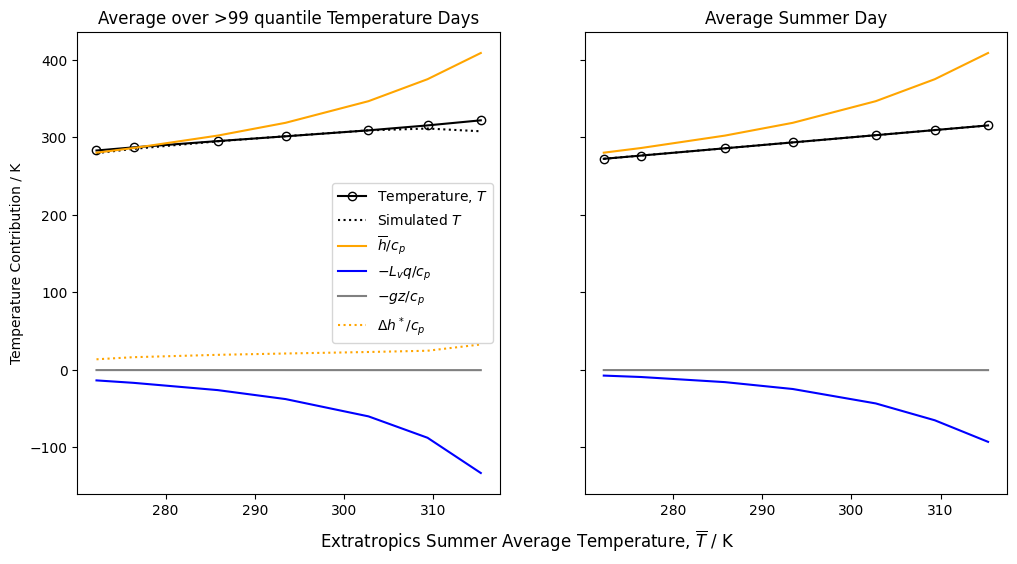

In [77]:
# Plot the different contributions to the temperature
fig, ax = plt.subplots(1,2, figsize=(12, 6), sharex=True, sharey=True)
ax[0].plot(temp_summer_av, temp_quant_av, marker='o',fillstyle='none', color='k', label='Temperature, $T$')
ax[0].plot(temp_summer_av, temp_quant_sim, linestyle=':', color='k', label='Simulated $T$')
ax[0].plot(temp_summer_av, h_mean_term, color='orange', label='$\overline{h}/c_p$')
ax[0].plot(temp_summer_av, q_term_quant, color='blue', label='$-L_v q/c_p$')
ax[0].plot(temp_summer_av, z_term_quant, color='grey', label='$-gz/c_p}$')
ax[0].plot(temp_summer_av, delta_h_term, color='orange', linestyle=':', label='$\Delta h^*/c_p$')
ax[0].legend()
ax[0].set_title(f'Average over >{quantile} quantile Temperature Days')

ax[1].plot(temp_summer_av, temp_summer_av, marker='o',fillstyle='none', color='k')
ax[1].plot(temp_summer_av, temp_summer_sim, linestyle=':', color='k')
ax[1].plot(temp_summer_av, h_mean_term, color='orange')
ax[1].plot(temp_summer_av, q_term_summer, color='blue')
ax[1].plot(temp_summer_av, z_term_summer, color='grey')
ax[1].set_title(f'Average Summer Day')

ax[0].set_ylabel('Temperature Contribution / K')
fig.supxlabel(f'{region} '+'Summer Average Temperature, $\overline{T}$ / K');

# ax[0].set_xlabel(f'{region} '+'Summer Average Temperature, $\overline{T}$ / K');



In the plots above, the simulated temperature (dotted black line) is the sum over all the temperature contributions (non black lines).

This differs for the extreme low and high temperatures from the actual temperature (solid black line) for the left hand plot because it is computed using the free troposphere $\Delta h$ value (dotted orange line). This is given by the dotted black line in the bottom plot in the previous figure. From this, you can see that this is significantly lower than the value computed using the surface values (solid black line) for the extreme high and low temperatures. If the plot was redone using the $\Delta h$ values computed using the surface value, then they would line up exactly.

## Temperature Gradient
We want to know why the temperature increases less on the warmest days than on the average summer day so we are really wanting to know why
the gradient $\delta T_x / \delta \overline{T} < 1$.

So we need to look at the decomposition of this gradient:
$$ \frac{\delta T_x}{\delta \overline{T}} = \frac{1}{c_p}(\frac{\delta \bar{h}}{\delta \overline{T}}
-g\frac{\delta z}{\delta \overline{T}} + \frac{\delta \Delta h^*}{\delta \overline{T}} -L_v \frac{\delta \bar{q_x}}{\delta \overline{T}}) $$

In [67]:
# Get gradient terms for high quantile days
temp_quant_grad = np.ediff1d(temp_quant_av) / np.ediff1d(temp_summer_av)
temp_quant_grad_terms = []
for var in [h_mean_term, delta_h_term, z_term_quant, q_term_quant]:
    temp_quant_grad_terms += [np.ediff1d(var) / np.ediff1d(temp_summer_av)]
temp_quant_grad_sim = [sum(x) for x in zip(*temp_quant_grad_terms)]

# Get gradient terms for summer day
temp_summer_grad = np.ediff1d(temp_summer_av) / np.ediff1d(temp_summer_av)
temp_summer_grad_terms = []
for var in [h_mean_term, z_term_summer, q_term_summer]:
    temp_summer_grad_terms += [np.ediff1d(var) / np.ediff1d(temp_summer_av)]

def moving_average(x, w):
    # Takes average over w consecutive values in x
    return np.convolve(x, np.ones(w), 'valid') / w

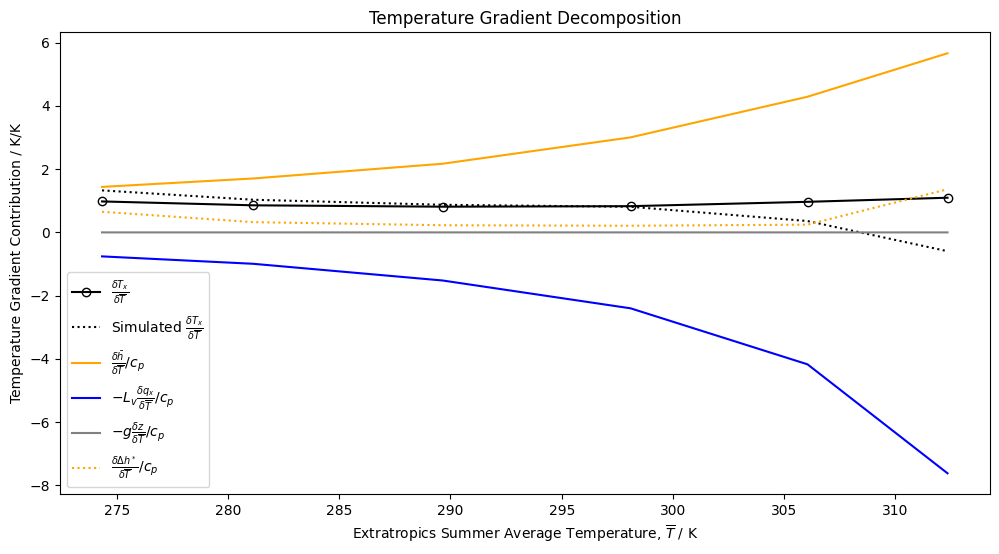

In [78]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad, marker='o',fillstyle='none', color='k',
        label='$\\frac{\delta T_x}{\delta \overline{T}}$')
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad_sim, color='k',
        label='Simulated $\\frac{\delta T_x}{\delta \overline{T}}$', linestyle=':')
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad_terms[0], color='orange',
        label='$\\frac{\delta \\bar{h}}{\delta \overline{T}}/c_p$')
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad_terms[3], color='blue',
        label='$-L_v\\frac{\delta q_x}{\delta \overline{T}}/c_p$')
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad_terms[2], color='grey',
        label='$-g\\frac{\delta z}{\delta \overline{T}}/c_p$')
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad_terms[1], color='orange', linestyle=':',
        label='$\\frac{\delta \Delta h^*}{\delta \overline{T}}/c_p$')
ax.legend()
ax.set_title('Temperature Gradient Decomposition')
ax.set_ylabel('Temperature Gradient Contribution / K/K')
ax.set_xlabel(f'{region} '+'Summer Average Temperature, $\overline{T}$ / K');

## Difference of gradient to average summer day
To make this a bit more clear I plot below the difference for each term from the equivalent term for the average summer day i.e.

$$\frac{\delta T_x}{\delta \overline{T}} - \frac{\delta \overline{T}}{\delta \overline{T}} = \frac{\delta T_x}{\delta \overline{T}} - 1
= \frac{1}{c_p}(\frac{\Delta h^*}{\delta \overline{T}} - g(\frac{\delta z_x}{\delta \overline{T}} - \frac{\delta \overline{z}}{\delta \overline{T}}) - L_v(\frac{\delta q_x}{\delta \overline{T}} - \frac{\delta \overline{q}}{\delta \overline{T}}))$$

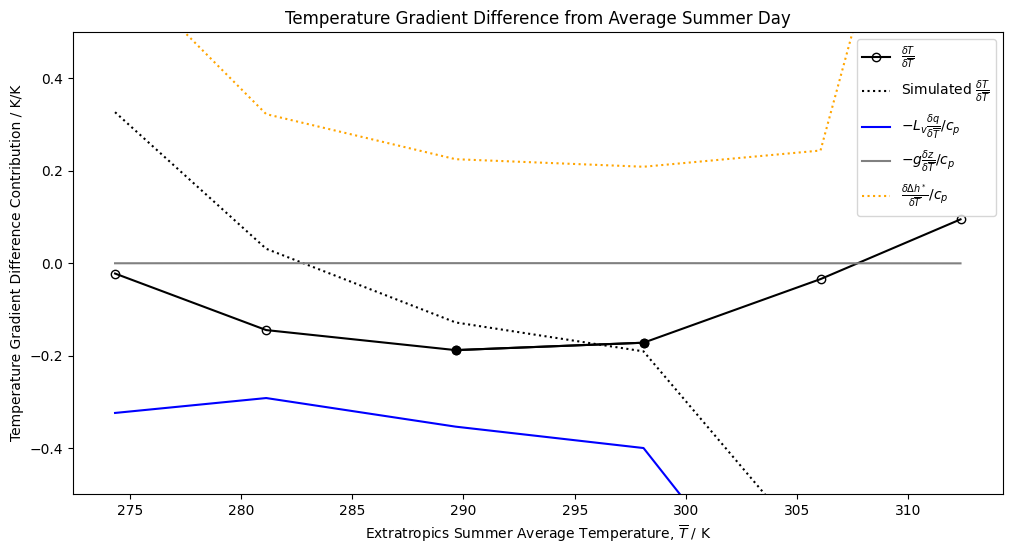

In [79]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad - temp_summer_grad, marker='o',fillstyle='none', color='k',
        label='$\\frac{\delta T}{\delta \overline{T}}$')
# Mark the simulations closest to convectively neutral
ax.plot(moving_average(temp_summer_av, 2)[2:4], temp_quant_grad[2:4] - temp_summer_grad[2:4], marker='o', color='k', fillstyle='full')
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad_sim - temp_summer_grad, color='k',
        label='Simulated $\\frac{\delta T}{\delta \overline{T}}$', linestyle=':')
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad_terms[3] - temp_summer_grad_terms[2], color='blue',
        label='$-L_v\\frac{\delta q}{\delta \overline{T}}/c_p$')
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad_terms[2] - temp_summer_grad_terms[1], color='grey',
        label='$-g\\frac{\delta z}{\delta \overline{T}}/c_p$')
ax.plot(moving_average(temp_summer_av, 2), temp_quant_grad_terms[1], color='orange', linestyle=':',
        label='$\\frac{\delta \Delta h^*}{\delta \overline{T}}/c_p$')
ax.legend()
ax.set_ylim([-0.5, 0.5])
ax.set_title('Temperature Gradient Difference from Average Summer Day')
ax.set_ylabel('Temperature Gradient Difference Contribution / K/K')
ax.set_xlabel(f'{region} '+'Summer Average Temperature, $\overline{T}$ / K');

From this, it is easiest looking at the two simulations marked with a black circle as for these the simulated value (dotted black line) matches well with the actual values (solid black line).

From these, we see that the gradient difference is negative because the specific humidity (blue line) is increasing faster than the moist static energy (dotted orange line).


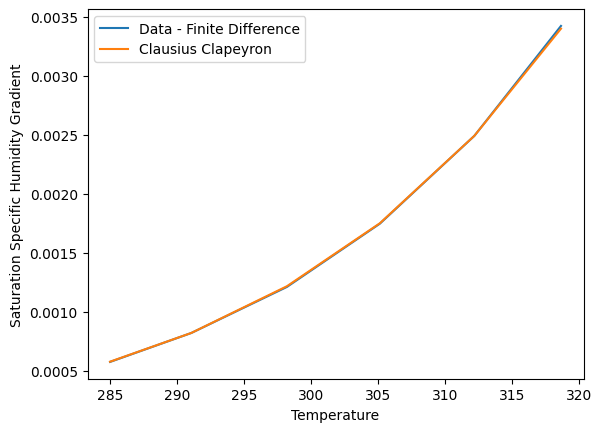

In [100]:
# Double check that the saturation specific humidity gradient is correct from clausius clapeyron as is from data
p_total = float(ds_summer[0].phalf[-1]) * 100  # total atmospheric pressure
def sphum_sat(temp):
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), p_total)
    q_sat = w_sat / (1+w_sat)
    return q_sat
def clausius_clapeyron_factor(temp):
    return L_v / (R_v * temp**2)
q_sat_grad = np.ediff1d(sphum_sat(temp_quant_av))/np.ediff1d(temp_quant_av)
q_sat_grad_pred = clausius_clapeyron_factor(moving_average(temp_quant_av,2)) * sphum_sat(moving_average(temp_quant_av,2))
plt.plot(moving_average(temp_quant_av,2), q_sat_grad, label='Data - Finite Difference')
plt.plot(moving_average(temp_quant_av,2), q_sat_grad_pred, label='Clausius Clapeyron')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Saturation Specific Humidity Gradient');

## Humidity Analysis
From the above plots, it is clear that the average summer day temperature increases more quickly with increased $CO_2$ than the high quantile days because the specific humidity increases more quickly on the high quantile days (i.e. the blue line is decreasing faster on the left hand side than the right hand side).

This is partially offset by the $\Delta h$ term (dotted orange line) increasing with $CO_2$ but this increase is much slower so is dominated by the specific humidity effect.



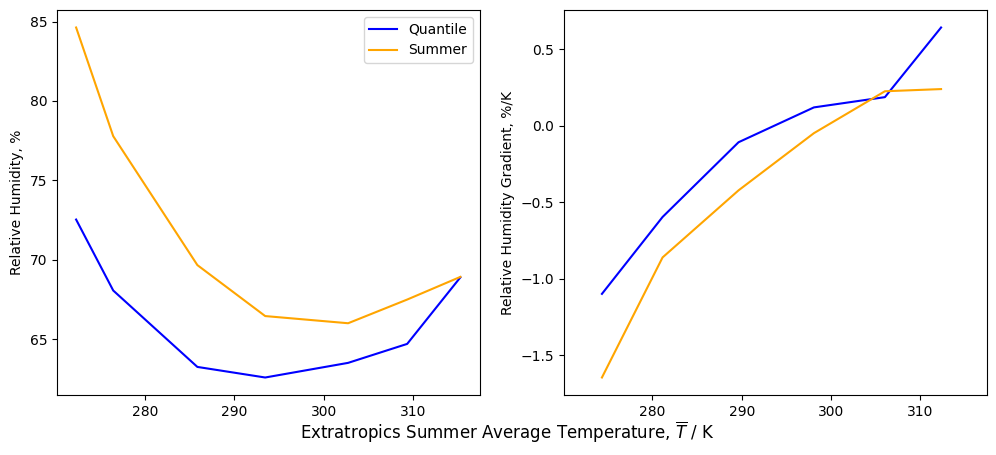

In [122]:
# Compute relative humidity
rhum_quant = rh_from_sphum(np.asarray([ds_quant[i].sphum[-1] for i in range(n_exp)]), temp_quant_av, p_total)
rhum_summer = rh_from_sphum(np.asarray([ds_summer[i].sphum[-1] for i in range(n_exp)]), temp_summer_av, p_total)

rhum_quant_grad = np.ediff1d(rhum_quant) / np.ediff1d(temp_quant_av)
rhum_summer_grad = np.ediff1d(rhum_summer) / np.ediff1d(temp_summer_av)

fig, ax = plt.subplots(1,2, figsize=(12, 5), sharex=True)
ax[0].plot(temp_summer_av, rhum_quant, color='b', label='Quantile')
ax[0].plot(temp_summer_av, rhum_summer, color='orange', label='Summer')
ax[0].legend()
ax[0].set_ylabel('Relative Humidity, %')

# X variable is mean between two temperatures used to compute the gradient
ax[1].plot(moving_average(temp_summer_av, 2), rhum_quant_grad, color='b', label='Quantile')
ax[1].plot(moving_average(temp_summer_av, 2), rhum_summer_grad, color='orange', label='Summer')
ax[1].set_ylabel('Relative Humidity Gradient, %/K')
fig.supxlabel(f'{region} '+'Summer Average Temperature, $\overline{T}$ / K');

From the above plot, the gradient of relative humidity with temperature is almost always greater on the high quantile days than on the average summer day.

Also, because the high quantile days are warmer than the mean summer day, the rate of increase of saturation specific humidity is always greater for the high quantile days. This is because saturation specific humidity increases exponentially with temperature according to Clauius Clapeyron, thus the gradient is always increasing.

These two reasons combined explain why the specific humidity increases faster for high quantile days than for the mean summer day.

In [123]:
rhum_quant

array([72.53591467, 68.06892878, 63.25832676, 62.59241333, 63.51373507,
       64.70748918, 68.9011584 ])